In [ ]:
from settings import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer

## Data Cleaning

In [ ]:
#Settings
%matplotlib inline
pd.set_option('display.max_columns', 97)

def read_features():
    
    raw_data = pd.read_csv("2016-SFO-Customer-Survey-Data.csv")
    
    data = raw_data.drop(DROP_COLS, axis = 1)
    return data

def prep_missing(data):
    
    # Survey codes blank/multiple responses as zeros. Replace all 0s and "0"s with NaN. 
    data = data.replace(0, np.nan)
    data = data.replace("0", np.nan)
    
    # Calculate threshold based on percentage of columns
    threshold = len(data.index) * PERCENT_MISSING
    
    # Find columns with missing data above a certain threshold
    high_missing = data.columns[data.isnull().sum() > threshold].tolist()
    
    # Keep only columns with low missing percentage from data
    imputables = data.drop(high_missing, axis=1)
    
    # Rename column names to human-readable text
    imputables_renamed = imputables.rename(columns=COLUMN_NAMES)
    return imputables_renamed

def encode_categories(data):
    
    label_encoder = LabelEncoder()
    encoded_categories = data.apply(label_encoder.fit_transform)
    return encoded_categories
 
def get_categoricals(categorical_data):
    
    categorical_columns = CAT_COLS
    
    categorical_features = categorical_data[categorical_columns]
         
    #Convert to categories dtype   
    for col in categorical_columns:
        categorical_features[col] = categorical_features[col].astype('category')
        
    #Remove erroneous responses
    categorical_features['Trav_age_group'] = categorical_features['Trav_age_group'].cat.remove_categories(['Under 18','Under 19', 'Under 20', 'Under 21', 'Under 22','Under 23', 'Under 24', 'Under 25', 'Under 26', 'Under 27', 'Under 28', 'Under 29', 'Under 30', 'Under 31', 'Under 32']) 
    
    categorical_data['Trav_age_group'] = categorical_data['Trav_age_group'].replace("Don't Know or Refused", "NaN")
    
    
    
    encoded_cats = pd.get_dummies(categorical_features)
    return categorical_features, encoded_cats

def get_numerics(numeric_data, cols_to_remove):
    
    numeric_data['Trav_Arr_to_dep_time'] = numeric_data['Trav_Arr_to_dep_time'].replace("N", "NaN")
    numeric_features = numeric_data.drop(cols_to_remove, axis=1)
    return numeric_features

def get_xy_vars(data, col_name):
    
    y = data[col_name]
    x = data.drop(col_name, axis=1)
    return y, x

def imputer(data, strategy):
    
    imp = Imputer(missing_values='NaN', strategy=strategy, axis=0)
    x_clean = imp.fit_transform(data)
    x_all = pd.DataFrame(x_clean, columns = data.columns) #Put column names back on
    return x_all

def barplot(data):
    
    chrt = 0
    fig = plt.figure(figsize=(20, 20))
    for col in data.columns:
        chrt+=1
        num_figs = len(data.columns)/4
        plt.xticks(rotation=90)
        plt.tight_layout()
        ax = fig.add_subplot(num_figs,5,chrt)
        sns.countplot(x=col, data=data)
    fig.show()


if __name__ == "__main__":
    
    data=read_features()
    
    prepped = prep_missing(data)
    
    cat_cols, dummy_cats = get_categoricals(prepped)
    nums = get_numerics(prepped, cat_cols)
    
    y_all, x_nums = get_xy_vars(nums, 'Rate_SFO_overall')
    
    imputed_nums = imputer(x_nums, 'median')
    
    x_all = pd.concat([imputed_nums,dummy_cats], axis=1)
    
    #TODO : Fix scale or truncate charts with many bins
    barplot(cat_cols)
    barplot(imputed_nums)

## Data exploration

#### Top 20 destinations for travelers flying out of SFO

In [113]:
topdests = cat_cols["Trav_Destination"].value_counts().nlargest(20)
toplists = topdests.index.tolist()
print topdests

LOS ANGELES          256
NEW YORK-JFK         223
SEATTLE              187
VANCOUVER            183
LAS VEGAS            146
CHICAGO-O'HARE        96
SALT LAKE CITY        94
TORONTO               87
PORTLAND              83
DENVER                73
SEOUL-INCHEON         69
PHOENIX               68
SAN DIEGO             68
DALLAS-FT. WORTH      58
WASHINGTON-DULLES     54
HOUSTON-BUSH          51
LONG BEACH            51
HONOLULU              51
BOSTON                50
ONTARIO (CALIF)       49
Name: Trav_Destination, dtype: int64


#### Most popular destinations by age group

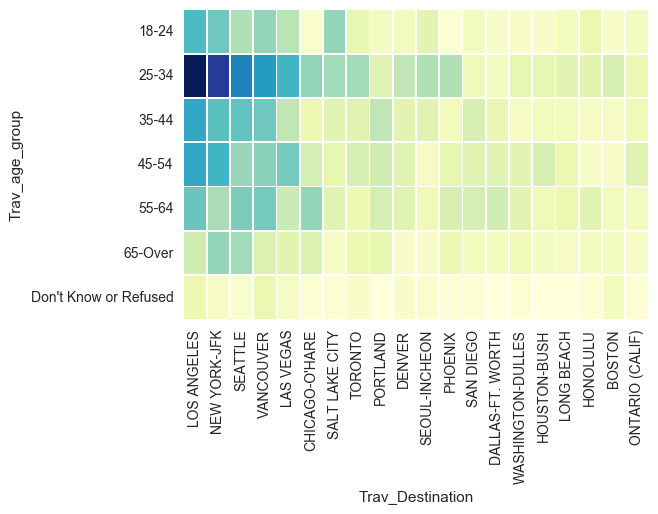

In [114]:
crosstab_dest = pd.crosstab(cat_cols["Trav_age_group"], cat_cols["Trav_Destination"])
crosstab_dest = crosstab_dest[toplists] 
sns.heatmap(crosstab_dest, linewidths=.5, cmap="YlGnBu", cbar=False)

#### Most popular destinations by gender

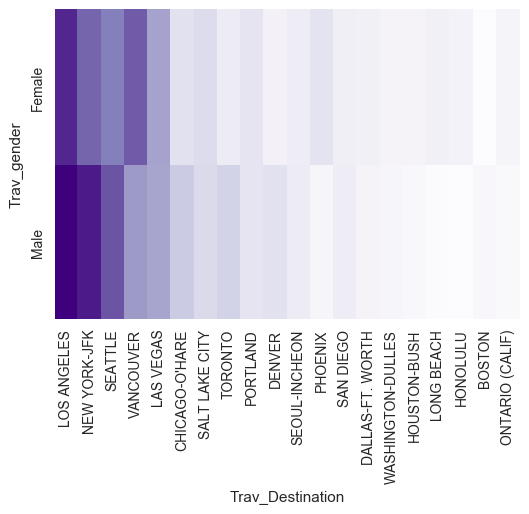

In [115]:
crosstab_gender = pd.crosstab(cat_cols["Trav_gender"], cat_cols["Trav_Destination"])
crosstab_gender = crosstab_gender[toplists] 
sns.heatmap(crosstab_gender, cmap="Purples", cbar=False)